<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#005097; border:0' role="tab" aria-controls="home"><center>APRENDIZADO DE MÁQUINA (CIC1205/GCC1932) - Trabalho 1</center></h1>

- Nome completo: <ALEXANDER_RAMOS_FEITOSA>
- [Link para vídeo](<LINK_VIDEO>)

# (1) Predição de pagamento de empréstimos

### Análise exploratória dos conjuntos de treino e teste

In [1]:
import pandas as pd


# Caminhos para os arquivos
train_path = "data/credtrain.txt"
test_path = "data/credtest.txt"

# Leitura dos arquivos, assumindo separador por tabulação e sem cabeçalho
df = pd.read_csv(train_path, sep="\t", header=None)
df_test = pd.read_csv(test_path, sep="\t", header=None)

# Verificação dos dados
print("Dados de treinamento:")
print(df.head())
print("\nDados de teste:")
print(df_test.head())

# Verifica se os dados estão balanceados
print("\nDistribuição de classes no conjunto de treinamento:")
print(df[11].value_counts())
print("\nDistribuição de classes no conjunto de teste:")
print(df_test[11].value_counts())

# Verifica se há valores ausentes
print("\nValores ausentes no conjunto de treinamento:")
print(df.isnull().sum())
print("\nValores ausentes no conjunto de teste:")
print(df_test.isnull().sum())




Dados de treinamento:
   0   1     2   3    4   5    6   7   8   9   10  11
0   1   0   360   0  313   9   52   0  25  48   0   1
1   0   0   350   1  468  10   65   0  33   6   0   1
2   0   0  1100   0  829   9  125   0  56  48   0   1
3   0   0  3000   0  552  12   76   1  31  60   0   1
4   1   0  1000   0  809  12  111   0  24   7   0   1

Dados de teste:
   0   1     2   3    4   5    6   7   8   9    10  11
0   0   2   500   1  618  10   85   0  36   6    0   0
1   1   0   813   0  552   4  119   0  43  48  119   1
2   3   0   350   0  488  12   66   0  43   0    0   1
3   1   0  1530   0  381   1  398   0  28  48    0   1
4   0   0   688   1  396  10   60   0  49  72    0   1

Distribuição de classes no conjunto de treinamento:
11
0    785
1    715
Name: count, dtype: int64

Distribuição de classes no conjunto de teste:
11
0    306
1    271
Name: count, dtype: int64

Valores ausentes no conjunto de treinamento:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8  

### Pré-processamento dos dados com a inclusão dos cabeçalhos, tratamento das variáveis categóricas e normalização das variáveis numéricas

In [2]:
# Preprocessamento dos dados
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

@dataclass
class DataDictionary:
    """Dicionário de dados do problema de crédito"""
    columns = {
        "ESCT": "Estado civil",
        "NDEP": "Número de dependentes",
        "RENDA": "Renda Familiar",
        "TIPOR": "Tipo de residência",
        "VBEM": "Valor do bem a ser adquirido",
        "NPARC": "Número de parcelas",
        "VPARC": "Valor da parcela",
        "TEL": "Se possui telefone",
        "IDADE": "Idade do cliente",
        "RESMS": "Tempo de moradia (meses)",
        "ENTRADA": "Valor da entrada",
        "CLASSE": "Cliente pagou a dívida (1=sim)"
    }
    
    # Definição das variáveis categóricas e numéricas
    categorical_features = ["ESCT", "NDEP", "TIPOR", "TEL"]
    numerical_features = ["RENDA", "VBEM", "NPARC", "VPARC", "IDADE", "RESMS", "ENTRADA"]
    target = "CLASSE"

    # Domínio de valores das variáveis categóricas
    categorical_domains = {
        "NDEP": range(8),    # 0 até 7
        "ESCT": range(1, 6), # 1 até 5
        "TIPOR": range(1, 4),# 1 até 3
        "TEL": [0, 1]        # binário
    }

class ProcessaDadosEmprestimos:
    """Classe para preprocessamento dos dados de empréstimos"""
        
    def __init__(self):
        self.scaler = MinMaxScaler()
        self.data_dict = DataDictionary()
        self.column_order = None
    
    def read_data(self, filepath: str) -> pd.DataFrame:
        """Lê os dados do arquivo e aplica o dicionário de dados"""
        df = pd.read_csv(filepath, sep='\t', header=None)
        df.columns = list(self.data_dict.columns.keys())
        return df
    
    def _encode_categorical(self, df: pd.DataFrame, is_training: bool = False) -> pd.DataFrame:
        """Codifica variáveis categóricas garantindo consistência entre treino e teste"""
        
        # Converte para categoria com domínios conhecidos
        for feature in self.data_dict.categorical_features:
            df[feature] = pd.Categorical(
                df[feature],
                categories=self.data_dict.categorical_domains[feature]
            )
        
        # One-hot encoding com todas as categorias
        encoded = pd.get_dummies(
            df[self.data_dict.categorical_features],
            prefix=self.data_dict.categorical_features,
            drop_first=True
        )
        
        if is_training:
            # Guarda ordem das colunas do treino
            self.column_order = encoded.columns
        else:
            # Garante mesmas colunas do treino
            for col in self.column_order:
                if col not in encoded.columns:
                    encoded[col] = 0
            encoded = encoded[self.column_order]
        
        return encoded
    
    def _scale_numerical(self, df: pd.DataFrame, is_training: bool = False) -> pd.DataFrame:
        """Escala variáveis numéricas usando MinMaxScaler"""
        if is_training:
            scaled_values = self.scaler.fit_transform(df[self.data_dict.numerical_features])
        else:
            scaled_values = self.scaler.transform(df[self.data_dict.numerical_features])
            
        return pd.DataFrame(
            scaled_values, 
            columns=self.data_dict.numerical_features,
            index=df.index
        )
    
    def process(self, df: pd.DataFrame, is_training: bool = False) -> Tuple[pd.DataFrame, pd.Series]:
        """Processa os dados aplicando todas as transformações necessárias"""
        # Codificação das variáveis categóricas
        encoded_cat = self._encode_categorical(df, is_training)
        
        # Escalonamento das variáveis numéricas
        scaled_num = self._scale_numerical(df, is_training)
        
        # Combina as features transformadas
        X = pd.concat([scaled_num, encoded_cat], axis=1)
        y = df[self.data_dict.target].astype('category')
        
        return X, y

def verify_preprocessing(X_train: pd.DataFrame, X_test: pd.DataFrame) -> None:
    """Verifica se o preprocessamento foi aplicado corretamente"""
    print("\nVerificação do preprocessamento:")
    print(f"Dimensões X_train: {X_train.shape}")
    print(f"Dimensões X_test: {X_test.shape}")
    
    # Verifica colunas categóricas
    cat_cols_train = [col for col in X_train.columns if any(cat in col for cat in ["ESCT", "NDEP", "TIPOR", "TEL"])]
    cat_cols_test = [col for col in X_test.columns if any(cat in col for cat in ["ESCT", "NDEP", "TIPOR", "TEL"])]
    
    print("\nColunas categóricas após encoding:")
    print(f"Treino: {sorted(cat_cols_train)}")
    print(f"Teste: {sorted(cat_cols_test)}")

def main():
    # Instancia o preprocessador
    preprocessor = ProcessaDadosEmprestimos()
    
    # Lê os dados
    df_train = preprocessor.read_data("data/credtrain.txt")
    df_test = preprocessor.read_data("data/credtest.txt")
    
    # Processa treino e teste
    X_train, y_train = preprocessor.process(df_train, is_training=True)
    X_test, y_test = preprocessor.process(df_test, is_training=False)
    
    # Verifica o preprocessamento
    verify_preprocessing(X_train, X_test)

    # Verifica os dados transformados
    print("\nDados transformados de treinamento:")
    print(X_train.head())
    print("\nDados transformados de teste:")
    print(X_test.head())


    return X_train, y_train, X_test, y_test

if __name__ == "__main__":
    X_train, y_train, X_test, y_test = main()


Verificação do preprocessamento:
Dimensões X_train: (1500, 21)
Dimensões X_test: (577, 21)

Colunas categóricas após encoding:
Treino: ['ESCT_2', 'ESCT_3', 'ESCT_4', 'ESCT_5', 'NDEP_1', 'NDEP_2', 'NDEP_3', 'NDEP_4', 'NDEP_5', 'NDEP_6', 'NDEP_7', 'TEL_1', 'TIPOR_2', 'TIPOR_3']
Teste: ['ESCT_2', 'ESCT_3', 'ESCT_4', 'ESCT_5', 'NDEP_1', 'NDEP_2', 'NDEP_3', 'NDEP_4', 'NDEP_5', 'NDEP_6', 'NDEP_7', 'TEL_1', 'TIPOR_2', 'TIPOR_3']

Dados transformados de treinamento:
      RENDA      VBEM     NPARC     VPARC     IDADE     RESMS  ENTRADA  \
0  0.007792  0.003514  0.347826  0.003026  0.117647  0.114286      0.0   
1  0.006494  0.045405  0.391304  0.022693  0.274510  0.014286      0.0   
2  0.103896  0.142973  0.347826  0.113464  0.725490  0.114286      0.0   
3  0.350649  0.068108  0.478261  0.039334  0.235294  0.142857      0.0   
4  0.090909  0.137568  0.478261  0.092284  0.098039  0.016667      0.0   

   ESCT_2  ESCT_3  ESCT_4  ...  NDEP_1  NDEP_2  NDEP_3  NDEP_4  NDEP_5  \
0   False   False

### Processamento com os algoritmos propostos


Treinando o modelo: Logistic Regression

Treinando o modelo: K-Nearest Neighbors

Treinando o modelo: Gradient Boosting


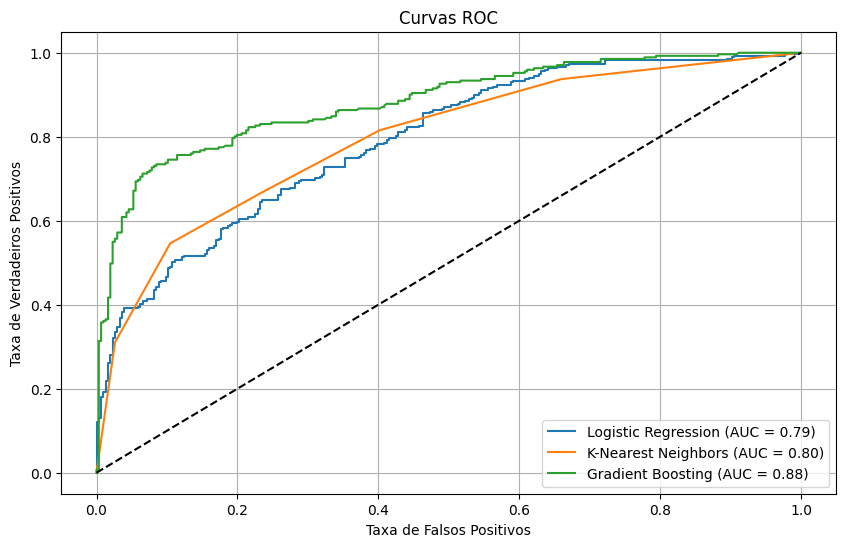

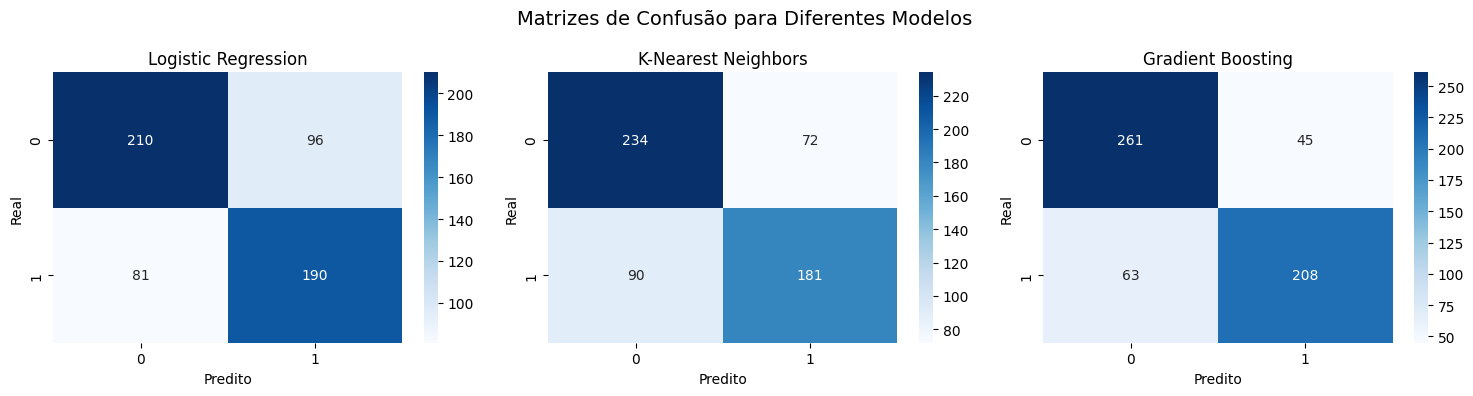


Relatório de Classificação para Logistic Regression:
              precision    recall  f1-score   support

           0       0.72      0.69      0.70       306
           1       0.66      0.70      0.68       271

    accuracy                           0.69       577
   macro avg       0.69      0.69      0.69       577
weighted avg       0.69      0.69      0.69       577


Relatório de Classificação para K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       306
           1       0.72      0.67      0.69       271

    accuracy                           0.72       577
   macro avg       0.72      0.72      0.72       577
weighted avg       0.72      0.72      0.72       577


Relatório de Classificação para Gradient Boosting:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       306
           1       0.82      0.77      0.79       271

    accuracy          

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrices(trained_models, X_test, y_test):
    """Plota as matrizes de confusão para cada modelo"""
    
    # Configuração do plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle('Matrizes de Confusão para Diferentes Modelos', fontsize=14)
    
    # Plotar matriz de confusão para cada modelo
    for (name, model), ax in zip(trained_models.items(), axes):
        # Faz predições
        y_pred = model.predict(X_test)
        
        # Calcula matriz de confusão
        cm = confusion_matrix(y_test, y_pred)
        
        # Plota matriz de confusão
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'{name}')
        ax.set_xlabel('Predito')
        ax.set_ylabel('Real')
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(X_test, y_test, trained_models):
    """Plota as curvas ROC para cada modelo"""
    
    plt.figure(figsize=(10, 6))
    
    for name, model in trained_models.items():
        # Calcula probabilidades
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calcula pontos da curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plota curva ROC
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # linha diagonal
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curvas ROC')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def train_and_evaluate(X_train, y_train, X_test, y_test):
    """Treina e avalia os modelos de classificação"""
    
    # Modelos a serem testados
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Gradient Boosting": GradientBoostingClassifier()
    }
    
    # Treina os modelos uma única vez
    trained_models = {}
    for name, model in models.items():
        print(f"\nTreinando o modelo: {name}")
        model.fit(X_train, y_train)
        trained_models[name] = model  # Guarda o modelo treinado
        
        # Previsões no conjunto de teste
        y_pred = model.predict(X_test)
    
    # Plota as curvas ROC usando os modelos já treinados
    plot_roc_curves(X_test, y_test, trained_models)
    
    # Plota as matrizes de confusão usando os mesmos modelos treinados
    plot_confusion_matrices(trained_models, X_test, y_test)

    # Avalia o desempenho dos modelos com o classification_report
    for name, model in trained_models.items():
        y_pred = model.predict(X_test)
        print(f"\nRelatório de Classificação para {name}:")
        print(classification_report(y_test, y_pred))
    
    return trained_models

# Uso do código
if __name__ == "__main__":
    # Assumindo que X_train, y_train, X_test, y_test já estão definidos
    trained_models = train_and_evaluate(X_train, y_train, X_test, y_test)

# (2) Predição de preços de diamantes

### Análise exploratória da base fornecida

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Leitura do arquivo original
df = pd.read_csv('data/diamonds.csv')
df.info()
print (df.head(10))





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB
   Unnamed: 0  carat        cut color clarity  depth  table  price     x  \
0           1   0.23      Ideal     E     SI2   61.5   55.0    326  3.95   
1           2   0.21    Premium     E     SI1   59.8   61.0    326  3.89   
2           3   0.23       Good     E     VS1   56.9   65.0    327  

### Pré-processamento com a codificação das variáveis categóricas, normalização das variáveis categóricas e  separação dos conjuntos de treino e teste

In [5]:
# Preprocessamento dos dados
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Preparação dos dados
# Remove a coluna Unnamed: 0 e separa features de target
X = df.drop(['Unnamed: 0', 'price'], axis=1)

# Codifica variáveis categóricas
le = LabelEncoder()
X['cut'] = le.fit_transform(X['cut'])
X['color'] = le.fit_transform(X['color'])
X['clarity'] = le.fit_transform(X['clarity'])

# Usando MinMaxScaler para as variáveis numéricas
numeric_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
scaler = MinMaxScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Define o target (price)
y = df['price']

# Separa os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def train_and_evaluate(X_train, y_train, X_test, y_test):
    """Treina e avalia os modelos de classificação"""



### Processamento e comparação dos resultados com os modelos propostos


Treinando Linear Regression...

Resultados para Linear Regression:
RMSE: 1351.2635
Coeficiente de Determinação: 0.8851

Treinando KNN...

Resultados para KNN:
RMSE: 891.7059
Coeficiente de Determinação: 0.9500

Treinando Gradient Boosting...

Resultados para Gradient Boosting:
RMSE: 655.6948
Coeficiente de Determinação: 0.9730


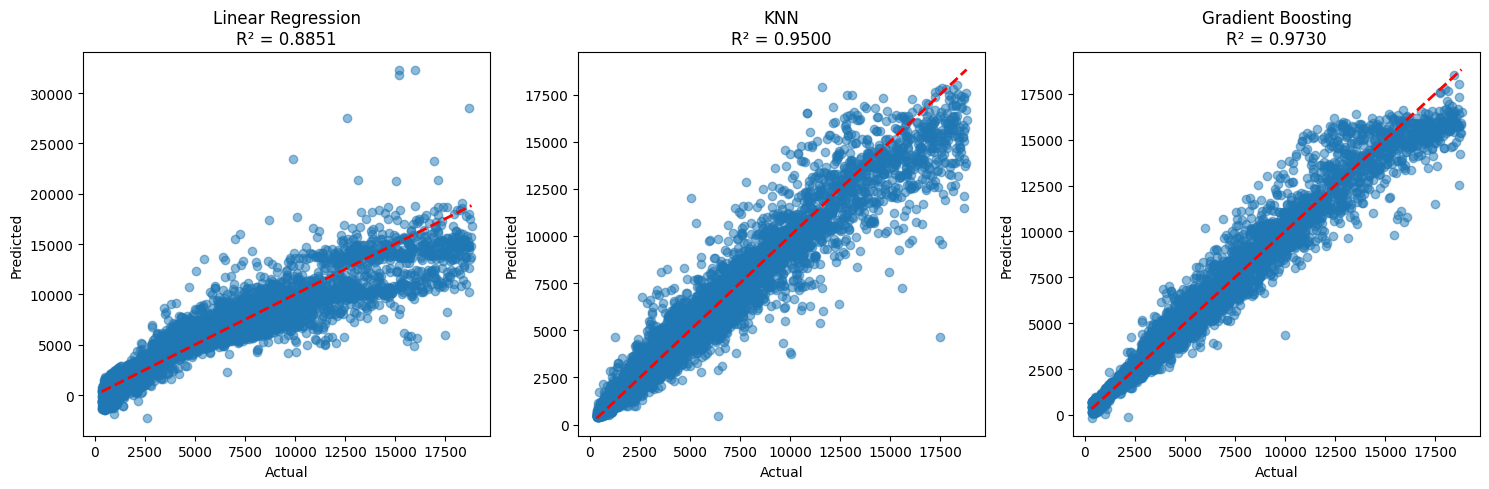

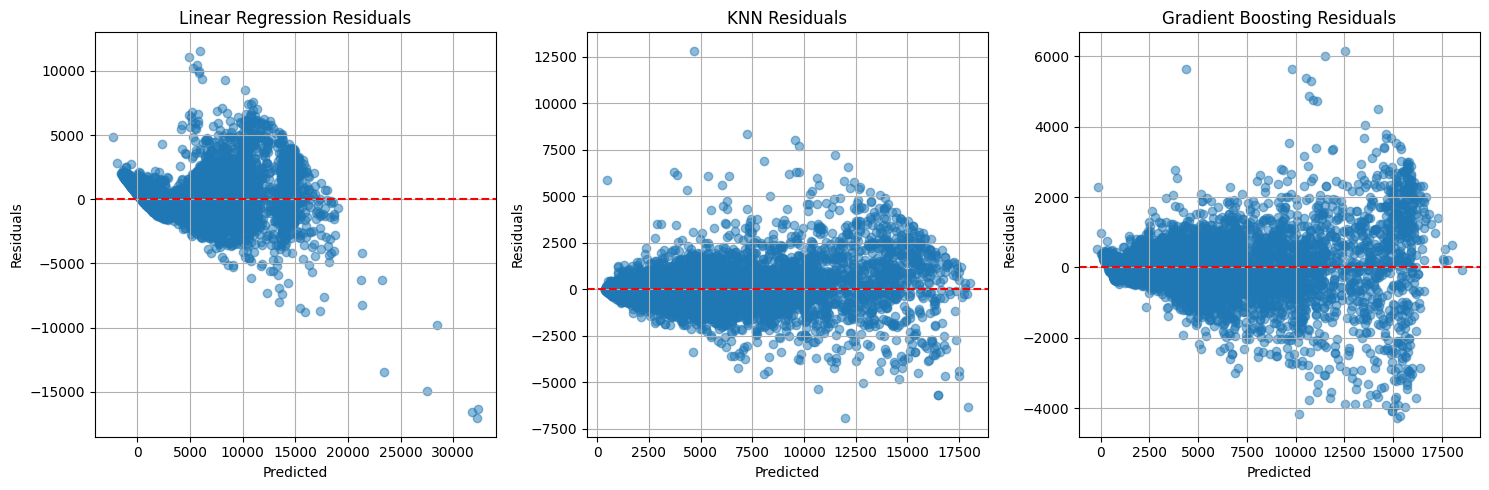

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Inicializa os modelos
models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Treina e avalia os modelos
results = {}
for name, model in models.items():
    # Treina o modelo
    print(f"\nTreinando {name}...")
    model.fit(X_train, y_train)
    
    # Faz previsões
    y_pred = model.predict(X_test)
    
    # Calcula métricas de desempenho
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
        
    # Armazena os resultados
    results[name] = {
        'R2': r2,
        'RMSE': rmse,
       
    }
    
    print(f"\nResultados para {name}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"Coeficiente de Determinação: {r2:.4f}")

# Plotagem dos resultados
plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    y_pred = model.predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{name}\nR² = {results[name]["R2"]:.4f}')

plt.tight_layout()
plt.show()

# Plotagem dos resíduos
residuals = y_test - y_pred
plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(f'{name} Residuals')
    plt.grid(True) 

plt.tight_layout()
plt.show()

# (3) Conjuntos desbalanceados - parte I

### Instruções iniciais 

In [ ]:
# Intruções Iniciais
import numpy as np
import pickle

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

f = open('data/A652.pickle', 'rb')

(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(f)
print(f"Shapes: ",X_train.shape, X_val.shape, X_test.shape)


# (4) Conjuntos desbalanceados - parte II

# (5) Calibração de modelos

# (6) Validação cruzada aninhada